#### Best Random Forest Model Predictions

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import lit
from pyspark.sql.functions import col, isnan, count, when, isnull, size, split
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, LongType, FloatType, DateType
from pyspark.sql.functions import col, regexp_replace
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier,GBTClassifier,RandomForestClassifier, RandomForestClassificationModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import 

In [2]:
spark = SparkSession.builder.appName('fine_tune_random_forest_attempt2_2').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/17 18:20:37 INFO org.apache.spark.SparkEnv: Registering MapOutputTracker
24/04/17 18:20:37 INFO org.apache.spark.SparkEnv: Registering BlockManagerMaster
24/04/17 18:20:37 INFO org.apache.spark.SparkEnv: Registering BlockManagerMasterHeartbeat
24/04/17 18:20:37 INFO org.apache.spark.SparkEnv: Registering OutputCommitCoordinator


In [3]:
# Load the transformed data
trainingDataPath = "gs://ds5460-tlee-spring2024/notebooks/jupyter/data/usa/combined_datasets/trainingDataTransformed.parquet"
testDataPath = "gs://ds5460-tlee-spring2024/notebooks/jupyter/data/usa/combined_datasets/dataWithZeroReviewTransformed.parquet"


# Load the data if necessary
reviews_data = spark.read.parquet(trainingDataPath)
zero_review_data = spark.read.parquet(testDataPath)

In [4]:
# Do 70/30 split on seed = 42 for consistency
train_data,test_data = reviews_data.randomSplit([0.7,0.3], seed=42)

In [5]:
# Specify the path where the model was saved - we are loading the best RF model
model_path = "gs://ds5460-tlee-spring2024/notebooks/jupyter//data/usa/combined_datasets/rfc_attempt_3"

# Load the model
loaded_model = RandomForestClassificationModel.load(model_path)

In [7]:
# Get the parameters of the best model
paramMap = loaded_model.extractParamMap()

print("Best Parameters:")
for param, value in paramMap.items():
    print(param.name, ":", value)

Best Parameters:
bootstrap : True
cacheNodeIds : False
checkpointInterval : 10
featureSubsetStrategy : auto
featuresCol : features
impurity : gini
labelCol : target_label
leafCol : 
maxBins : 2200
maxDepth : 12
maxMemoryInMB : 256
minInfoGain : 0.0
minInstancesPerNode : 1
minWeightFractionPerNode : 0.0
numTrees : 20
predictionCol : prediction
probabilityCol : probability
rawPredictionCol : rawPrediction
seed : -7654899084765008812
subsamplingRate : 1.0


In [6]:
predictions = loaded_model.transform(test_data)

# Display some predictions as a check
predictions.select("prediction", "probability", "target_label").show(5)

24/04/14 04:44:19 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 5.3 MiB


+----------+--------------------+------------+
|prediction|         probability|target_label|
+----------+--------------------+------------+
|       0.0|[0.63710250574558...|         0.0|
|       0.0|[0.58083432936249...|         0.0|
|       0.0|[0.55474491242041...|         0.0|
|       0.0|[0.54425342356561...|         1.0|
|       0.0|[0.63804357894977...|         2.0|
+----------+--------------------+------------+
only showing top 5 rows



In [7]:
# Counting the occurrences of each value in the “target_label” column - which is the ground truth
target_label_counts = predictions.groupBy("target_label").count()
# Counting the occurrences of each value in the “prediction” column
prediction_counts = predictions.groupBy("prediction").count()
# Displaying the counts
print("Target Label Counts:")
target_label_counts.show()
print("Prediction Counts:")
prediction_counts.show()

Target Label Counts:


+------------+-----+
|target_label|count|
+------------+-----+
|         0.0|21242|
|         1.0|18960|
|         2.0| 3010|
+------------+-----+

Prediction Counts:


24/04/14 04:44:25 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 5.3 MiB
24/04/14 04:44:28 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 5.3 MiB
24/04/14 04:44:28 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 5.3 MiB


+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|24500|
|       1.0|18373|
|       2.0|  339|
+----------+-----+



In [8]:
evaluator = MulticlassClassificationEvaluator(labelCol="target_label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Accuracy = {:.2f}%".format(accuracy * 100))


# To calculate F1 Score
f1_evaluator = MulticlassClassificationEvaluator(labelCol="target_label", 
                                                 predictionCol="prediction", 
                                                 metricName="f1")

f1_score = f1_evaluator.evaluate(predictions)  # Assuming 'predictions' is your dataframe with predictions
print("F1 Score = {:.2f}%".format(f1_score * 100))

# To calculate weighted Precision
precision_evaluator = MulticlassClassificationEvaluator(labelCol="target_label", 
                                                        predictionCol="prediction", 
                                                        metricName="weightedPrecision")

precision_score = precision_evaluator.evaluate(predictions)

print("Precision Score = {:.2f}%".format(precision_score * 100))
# To calculate weighted Recall
recall_evaluator = MulticlassClassificationEvaluator(labelCol="target_label", 
                                                     predictionCol="prediction", 
                                                     metricName="weightedRecall")

recall_score = recall_evaluator.evaluate(predictions)
print("Recall Score = {:.2f}%".format(recall_score * 100))
# Count predictions
confusion_matrix = predictions.groupBy('target_label').pivot('prediction', [0,1,2]).count().na.fill(0).orderBy('target_label')
confusion_matrix.show()

24/04/14 04:44:29 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 5.3 MiB


Test Accuracy = 60.01%


24/04/14 04:44:31 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 5.3 MiB


F1 Score = 58.22%


24/04/14 04:44:34 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 5.3 MiB


Precision Score = 59.18%


24/04/14 04:44:36 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 5.3 MiB


Recall Score = 60.01%


24/04/14 04:44:38 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 5.3 MiB
24/04/14 04:44:41 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 5.3 MiB
24/04/14 04:44:42 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 5.3 MiB


+------------+-----+-----+---+
|target_label|    0|    1|  2|
+------------+-----+-----+---+
|         0.0|15115| 6010|117|
|         1.0| 8252|10652| 56|
|         2.0| 1133| 1711|166|
+------------+-----+-----+---+



Note: accuracy and weighted recall in this case are identical because recall for a multiclass classification problem in PySpark, when using "weightedRecall", is the same as accuracy.

In [9]:
# Create confusion matrix: actual vs predicted
confusion_matrix = predictions.crosstab("target_label", "prediction")
# Show confusion matrix
confusion_matrix.show(truncate=False)

24/04/14 04:53:38 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 5.3 MiB
24/04/14 04:53:40 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 5.3 MiB
24/04/14 04:53:40 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 5.3 MiB


+-----------------------+-----+-----+---+
|target_label_prediction|0.0  |1.0  |2.0|
+-----------------------+-----+-----+---+
|2.0                    |1133 |1711 |166|
|1.0                    |8252 |10652|56 |
|0.0                    |15115|6010 |117|
+-----------------------+-----+-----+---+



In [10]:
# Collect data to the driver
target_label_counts_df = target_label_counts.toPandas()
prediction_counts_df = prediction_counts.toPandas()

# Renaming columns to avoid confusion
target_label_counts_df.columns = ['label', 'true_count']
prediction_counts_df.columns = ['label', 'predicted_count']

24/04/14 04:55:18 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 5.3 MiB
24/04/14 04:55:21 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 5.3 MiB


In [11]:
combined_df = pd.merge(target_label_counts_df, prediction_counts_df, on='label', how='outer').fillna(0)

# Mapping numerical labels to listing rating categories
label_map = {0: 'Great', 1: 'Average', 2: 'Poor'}
combined_df['label'] = combined_df['label'].map(label_map)

# Have labels in proper order
combined_df['label'] = pd.Categorical(combined_df['label'], categories=['Poor', 'Average', 'Great'], ordered=True)
combined_df.sort_values('label', inplace=True)

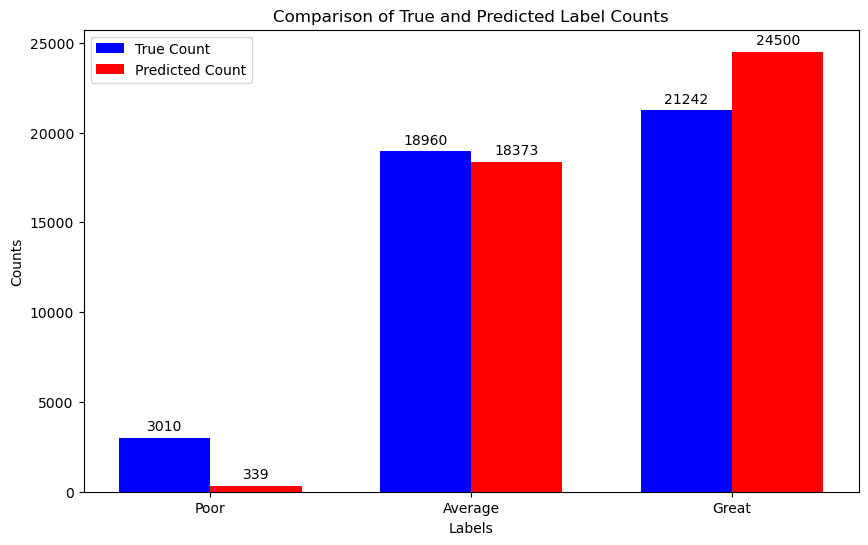

In [13]:
# Create bar plot on ground truth vs. predicted
bar_width = 0.35
index = np.arange(len(combined_df['label']))

fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(index - bar_width/2, combined_df['true_count'], bar_width, label='True Count', color='b')
bar2 = ax.bar(index + bar_width/2, combined_df['predicted_count'], bar_width, label='Predicted Count', color='r')

ax.set_xlabel('Labels')
ax.set_ylabel('Counts')
ax.set_title('Comparison of True and Predicted Label Counts')
ax.set_xticks(index)
ax.set_xticklabels(combined_df['label'])
ax.legend()

# Adding text labels above the bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bar1)
add_labels(bar2)

plt.show()

### Create graphic on how much percent predicted class is off from ground truth

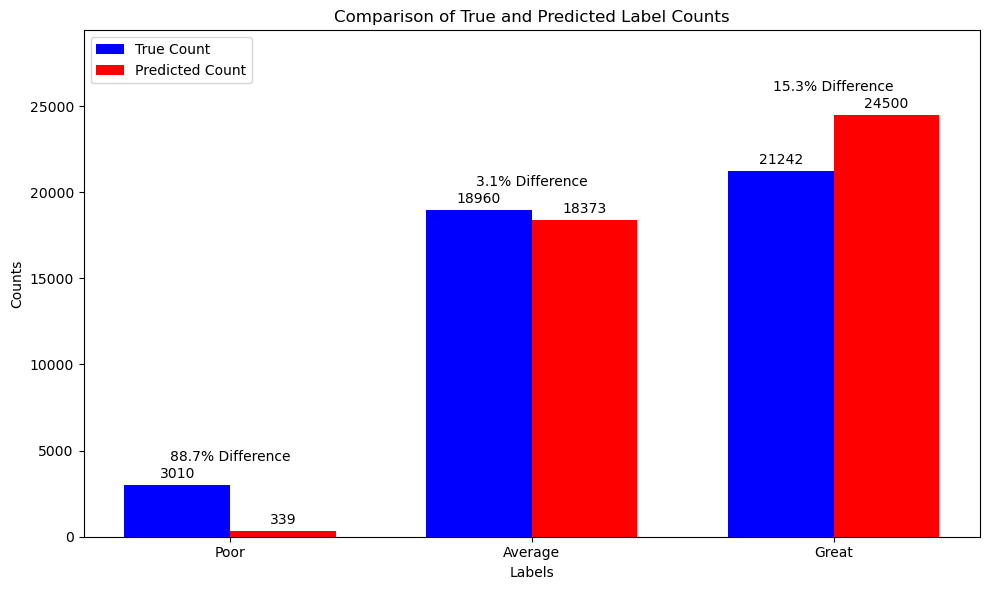

In [34]:
# Create bar plot on ground truth vs. predicted
bar_width = 0.35
index = np.arange(len(combined_df['label']))

fig, ax = plt.subplots(figsize=(10, 6))  # Adjusting figure size to accommodate legend
bar1 = ax.bar(index - bar_width/2, combined_df['true_count'], bar_width, label='True Count', color='b')
bar2 = ax.bar(index + bar_width/2, combined_df['predicted_count'], bar_width, label='Predicted Count', color='r')

ax.set_xlabel('Labels')
ax.set_ylabel('Counts')
ax.set_title('Comparison of True and Predicted Label Counts')
ax.set_xticks(index)
ax.set_xticklabels(combined_df['label'])

# Adding text labels above the bars for counts
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bar1)
add_labels(bar2)

# Calculate and annotate percentage difference with the word "Difference"
for i, (true_count, predicted_count) in enumerate(zip(combined_df['true_count'], combined_df['predicted_count'])):
    percentage_diff = abs(true_count - predicted_count) / true_count * 100
    # Adjust the y-coordinate for annotation to be above the highest bar + some offset
    y_coordinate = max(true_count, predicted_count) + 0.05 * max(combined_df['true_count'].max(), combined_df['predicted_count'].max())
    ax.annotate(f'{percentage_diff:.1f}% Difference', 
                xy=(index[i], y_coordinate),
                ha='center', va='bottom')

# Move the legend to the side of the plot
ax.legend(loc='upper left')

# Adjust the ylim to accommodate the annotations, considering the new text added
plt.ylim(0, 1.2 * max(combined_df['true_count'].max(), combined_df['predicted_count'].max()))

plt.tight_layout()  # Ensure the plot is nicely fit in the figure
plt.show()

In [14]:
# Create feature importance graphic
feature_names = ['host_is_superhost_indexed', 'city_indexed', 'room_type_indexed', 'full_time_host_indexed',
                 'host_verifications_clean_indexed', 'host_total_listings_count', 'accommodates', 'num_bath', 
                 'bedrooms', 'beds', 'price', 'amenities_count', 'essential_amenities']

# Retrieve feature importances from the model
importances = loaded_model.featureImportances

# Convert feature importances to a list
importances_list = importances.toArray()

# Create a list of tuples (featureName, importance) and sort them by importance
feature_importance_list = sorted(zip(feature_names, importances_list), key=lambda x: x[1], reverse=True)


for feature, importance in feature_importance_list:
    print(f"{feature}: {importance:.4f}")

host_total_listings_count: 0.2413
host_is_superhost_indexed: 0.1402
amenities_count: 0.1284
city_indexed: 0.1238
price: 0.1146
accommodates: 0.0486
full_time_host_indexed: 0.0404
beds: 0.0344
num_bath: 0.0343
host_verifications_clean_indexed: 0.0262
essential_amenities: 0.0261
bedrooms: 0.0224
room_type_indexed: 0.0194


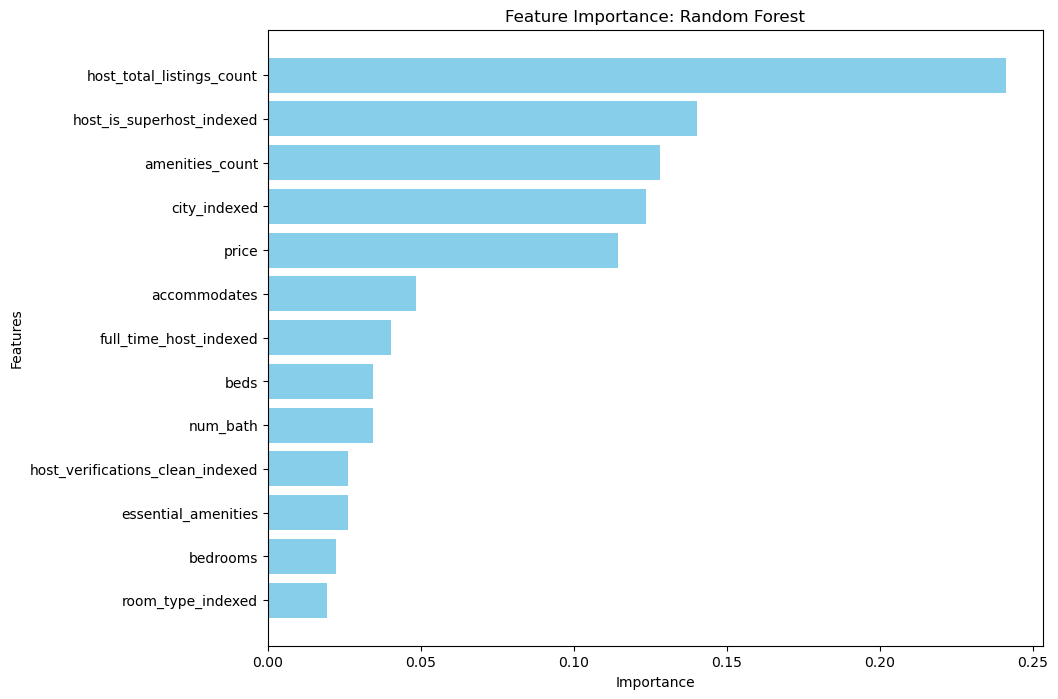

In [37]:
df_importances = pd.DataFrame(feature_importance_list, columns=['Feature', 'Importance'])

# Sort the DataFrame by importance
df_importances.sort_values(by='Importance', ascending=True, inplace=True)

# Show the feature importance graphic
plt.figure(figsize=(10, 8))
plt.barh(df_importances['Feature'], df_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance: Random Forest')
plt.show()

#### Zero Review Predictions

In [16]:
zero_predictions = loaded_model.transform(zero_review_data)

In [17]:
zero_predictions.select("prediction", "probability").show(5)

24/04/14 04:56:19 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 5.3 MiB


+----------+--------------------+
|prediction|         probability|
+----------+--------------------+
|       0.0|[0.53018945502556...|
|       1.0|[0.37907244877478...|
|       1.0|[0.47205169337608...|
|       1.0|[0.43147584525270...|
|       0.0|[0.66722692156461...|
+----------+--------------------+
only showing top 5 rows



In [18]:
# Counting the occurrences of each prediction value
prediction_counts_zero = zero_predictions.groupBy("prediction").count()

# Collecting the data to the driver for plotting
prediction_counts_zero_df = prediction_counts_zero.toPandas()

# Mapping prediction numeric values to proper listing rating's label
label_map = {0: 'Great', 1: 'Average', 2: 'Poor'}
prediction_counts_zero_df['label'] = prediction_counts_zero_df['prediction'].map(label_map)

24/04/14 04:56:20 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 5.3 MiB
24/04/14 04:56:21 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 5.3 MiB


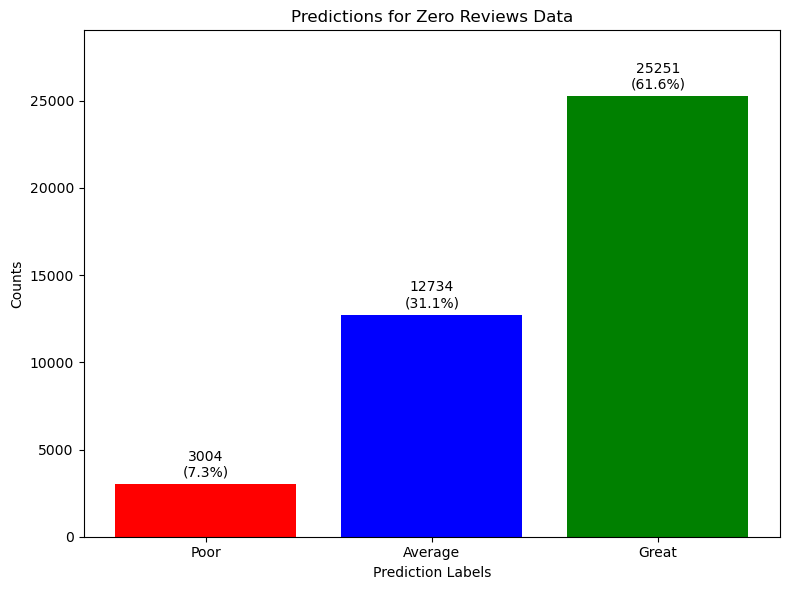

In [21]:
prediction_counts_zero_df['label'] = pd.Categorical(prediction_counts_zero_df['label'],
                                                    categories=['Poor', 'Average', 'Great'],
                                                    ordered=True)

prediction_counts_zero_df.sort_values('label', inplace=True)

plt.figure(figsize=(8, 6))
bars = plt.bar(prediction_counts_zero_df['label'], prediction_counts_zero_df['count'], color=['red', 'blue', 'green'])
plt.xlabel('Prediction Labels')
plt.ylabel('Counts')
plt.title('Predictions for Zero Reviews Data')

# Calculate total number of predictions
total_predictions = prediction_counts_zero_df['count'].sum()

# Find the maximum value to set ylim
max_count = prediction_counts_zero_df['count'].max()

# Adding text label count above the bars and adjusting the ylim
for bar in bars:
    yval = bar.get_height()
    percentage = f'{100 * yval / total_predictions:.1f}%' 
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01 * max_count, f'{yval}\n({percentage})', ha='center', va='bottom')

plt.ylim(0, max_count + 0.15 * max_count)

plt.tight_layout()

plt.show()

#### Save zero_predictions into parquet

In [90]:
# Just adding the columns instead of dropping it to be the number of features just in case
detailed_predictions = zero_predictions.withColumn("prediction", F.col("prediction"))\
                                       .withColumn("probability", F.col("probability"))

In [91]:
# Specify the GCS bucket path where the CSV file will be saved
output_path = "gs://ds5460-tlee-spring2024/notebooks/jupyter/data/usa/combined_datasets/zero_review_results"

detailed_predictions.write.parquet(output_path, mode="overwrite")

24/04/13 07:38:04 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 5.5 MiB


In [92]:
# Read parquet file in to double check
parquet_path = "gs://ds5460-tlee-spring2024/notebooks/jupyter/data/usa/combined_datasets/zero_review_results"

# Read the Parquet file
check_parquet = spark.read.parquet(parquet_path)

In [94]:
# Print the schema of the DataFrame
check_parquet.printSchema()

root
 |-- id: long (nullable = true)
 |-- host_id: integer (nullable = true)
 |-- host_since: string (nullable = true)
 |-- host_location: string (nullable = true)
 |-- host_is_superhost: string (nullable = true)
 |-- host_listings_count: double (nullable = true)
 |-- host_total_listings_count: double (nullable = true)
 |-- host_has_profile_pic: string (nullable = true)
 |-- host_identity_verified: string (nullable = true)
 |-- neighborhood: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- room_type: string (nullable = true)
 |-- accommodates: integer (nullable = true)
 |-- num_bath: double (nullable = true)
 |-- bedrooms: double (nullable = true)
 |-- beds: double (nullable = true)
 |-- price: double (nullable = true)
 |-- calculated_host_listings_count: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- amenities_count: integer (nullable = true)
 |-- neighborhood_city: string (nullable = true)
 |-- full_tim

In [98]:
# Calculate the average of 'amenities_count' grouped by 'prediction' as a check on the parquet file
check_parquet.groupBy('prediction').avg('amenities_count').show()

+----------+--------------------+
|prediction|avg(amenities_count)|
+----------+--------------------+
|       0.0|  26.650033662033188|
|       1.0|  30.423433328098007|
|       2.0|  16.915113182423436|
+----------+--------------------+



In [99]:
spark.stop()